In [16]:
import sklearn as sk
import pandas as pd
import warnings
warnings.simplefilter("ignore")

In [17]:
# First, lets construct the different models that we will use.
from sklearn import tree
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import svm
from sklearn import neural_network
from sklearn import ensemble

# Read data-engineered CSV.
df = pd.read_csv('H-2B_Engineered_Data.csv')
labels = df.loc[:,'CASE_STATUS']
features = pd.DataFrame(df.drop(labels = ['CASE_STATUS'], axis = 1))

We will use a pipeline for hosting three steps to take place on the training data within the cross-validation loop:

Preprocessing (scaling numeric features, one-hot encoding categorical features), PCA (to reduce dimensionality, especially considering the expansion in dimensionality associated with the one-hot encoding), and class balancing.

This notebook is used to test the ClusterCentroids majority class undersampling method, which replaces clusters of majority samples with the cluster centroids determined by a KMeans algorithm on the majority samples, and a random oversampling method for the minority class, as a means of performing class balancing. 

In [4]:
from sklearn import decomposition
from sklearn import preprocessing as pp
from sklearn import neighbors as knn
from sklearn import pipeline
from sklearn import model_selection
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import RandomOverSampler

# Build a preprocessor to scale numeric features and one hot encode categorical features.
numeric_features = ['NBR_WORKERS_REQUESTED', 
                    'BASIC_NUMBER_OF_HOURS', 
                    'BASIC_RATE_OF_PAY', 
                    'SUPERVISE_HOW_MANY', 
                    'NUM_OF_MONTHS_TRAINING',
                    'EMP_EXP_NUM_MONTHS',
                    'WORK_DAY_LENGTH']
categorical_features = ["AGENT_POC_EMP_REP_BY_AGENT", 
                        "SOC_CODE", 
                        "NAICS_CODE", 
                        "FULL_TIME_POSITION", 
                        "NATURE_OF_TEMPORARY_NEED", 
                        "EDUCATION_LEVEL", 
                        "SWA_NAME", 
                        "CITY_MATCH", 
                        "STATE_MATCH", 
                        "DAYTIME_WORK", 
                        "HAS_OVERTIME"]

# Get indices of numeric and categorical feature columns in dataframe.
numeric_feature_names = set(numeric_features)
categorical_feature_names = set(categorical_features)

numeric_feature_indices = []
categorical_feature_indices = []

for index, column_name in enumerate(features.columns):
    if column_name in numeric_feature_names:
        numeric_feature_indices.append(index)
    elif column_name in categorical_feature_names:
        categorical_feature_indices.append(index)

# Scale numeric features.
numeric_transformer = pipeline.Pipeline(steps=[
    ('scaler', pp.StandardScaler())])

# One-hot encode categorical features.
categorical_transformer = pipeline.Pipeline(steps=[
    ('onehot', pp.OneHotEncoder(sparse = False, handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_feature_indices),
        ('cat', categorical_transformer, categorical_feature_indices)])
        
# Utilize the cluster centroids undersampling and the random oversampling methods.
random_state_val = 123
undersample = ClusterCentroids(sampling_strategy = 0.33, random_state = random_state_val)
oversample = RandomOverSampler(sampling_strategy = 1, random_state = random_state_val)

Visualization of datapoint distribution, post pre-processing and PCA:

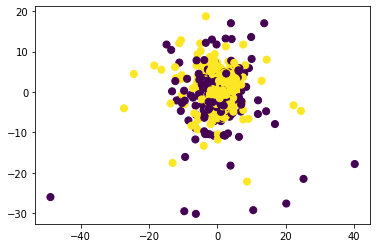

In [7]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
%matplotlib inline

fitted_features = preprocessor.fit_transform(features)
pca_features = decomposition.PCA().fit_transform(fitted_features)

def scatter(data, labels):
    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(data[:, :-1])
    plt.scatter(mds_data[:, 0], mds_data[:, 1], c=labels, s=50)
    plt.show()

scatter(pca_features, labels)

As can be seen from this visualization, there may be difficulties associated with accurately distinguishing between samples from the majority and minority classes, and this may be reflected in diminished precision and recall scores associated with identifying the minority class.

Here, we'll be determining the best parameters for Decision Tree, K Nearest Neighbors, SVM, Random Forest Classifier, and MLP Classifier.

In [8]:
# Decision Tree
# Testing additional parameters takes excessive amount of time, unable to run to completion.
tuned_parameters = {
    'tree__max_depth': [5, 10, 15, 20],
}
pipe = Pipeline(steps = [('preprocess', preprocessor), ('dim', decomposition.PCA()), ('undersample', undersample), ('oversample', oversample), ('tree', tree.DecisionTreeClassifier())])
tree_model = GridSearchCV(pipe, param_grid=tuned_parameters, scoring='accuracy', cv=5)
tree_model.fit(features, labels)
print(tree_model.best_params_)
print(tree_model.best_score_)

{'tree__max_depth': 5}
0.8255351681957187


In [9]:
# K Nearest Neighbors
tuned_parameters = {
    'knn__n_neighbors': list(range(1, 25))
}
pipe = Pipeline(steps = [('preprocess', preprocessor), ('dim', decomposition.PCA()), ('undersample', undersample), ('oversample', oversample), ('knn', neighbors.KNeighborsClassifier())])
knn_model = GridSearchCV(pipe, param_grid=tuned_parameters, scoring='accuracy', cv=5)
knn_model.fit(features, labels)
print(knn_model.best_params_)
print(knn_model.best_score_)

{'knn__n_neighbors': 1}
0.8134556574923547


In [10]:
from sklearn.svm import LinearSVC

# Linear Support Vector Classifier
# Again, since undersampling / oversampling takes longer than solely applying SMOTENC,
# testing additional hyperparameters takes excessive amount of time, unable to run to completion.
tuned_parameters = {
    "svm__loss": ['hinge', 'squared_hinge'],
}

svc = LinearSVC()

pipe = Pipeline(steps = [('preprocess', preprocessor), ('dim', decomposition.PCA()), ('undersample', undersample), ('oversample', oversample), ('svm', svc)])
svm_model = GridSearchCV(pipe, param_grid=tuned_parameters, scoring='accuracy', cv=5)
svm_model.fit(features, labels)
print(svm_model.best_params_)
print(svm_model.best_score_)

{'svm__loss': 'squared_hinge'}
0.8307339449541284


In [11]:
# Neural Network
tuned_parameters = {
    'net__activation': ['logistic', 'tanh', 'relu'],
    'net__solver': ['sgd', 'adam']
}
pipe = Pipeline(steps = [('preprocess', preprocessor), ('dim', decomposition.PCA()), ('undersample', undersample), ('oversample', oversample), ('net', neural_network.MLPClassifier())])
net_model = GridSearchCV(pipe, param_grid=tuned_parameters, scoring='accuracy', cv=5)
net_model.fit(features, labels)
print(net_model.best_params_)
print(net_model.best_score_)

warnings.simplefilter("default")

{'net__activation': 'logistic', 'net__solver': 'sgd'}
0.8351681957186544


In [12]:
warnings.simplefilter("ignore")
# Random Forest Classifier
tuned_parameters = {
    'rfc__max_depth': list(range(35, 56)),
    'rfc__min_samples_leaf': list(range(8, 13, 2)),
    'rfc__max_features': ['sqrt', 'log2']
}

pipe = Pipeline(steps = [('preprocess', preprocessor), ('dim', decomposition.PCA()), ('undersample', undersample), ('oversample', oversample), ('rfc', ensemble.RandomForestClassifier(n_estimators=10))])
rfc_model = GridSearchCV(pipe, param_grid=tuned_parameters, scoring='accuracy', cv=5)
rfc_model.fit(features, labels)
print(rfc_model.best_params_)
print(rfc_model.best_score_)

{'rfc__max_depth': 55, 'rfc__max_features': 'log2', 'rfc__min_samples_leaf': 8}
0.8123853211009174


Now, we create our classifiers based on the best tuned parameters.

We use these classifiers to create an ensemble voting classifier, hosting a Decision Tree, Random Forest, KNN, Gaussian Naive Bayes, Linear Support Vector Classifier, and Neural Network classifier.

In [18]:
classifiers = []

# Classifiers.
tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
classifiers.append(('tree', tree))

rfc = ensemble.RandomForestClassifier(n_estimators=10, max_depth=55, max_features='log2', min_samples_leaf=8)
classifiers.append(('rfc', rfc))

knn = neighbors.KNeighborsClassifier(n_neighbors=1)
classifiers.append(('knn', knn))

nb = naive_bayes.GaussianNB()
classifiers.append(('nb', nb))

sv = LinearSVC(loss='squared_hinge')
classifiers.append(('svm', sv))

net = neural_network.MLPClassifier(activation='logistic', solver='sgd')
classifiers.append(('neural_network', net))

In [19]:
# Results from the Individual Classifiers.

warnings.simplefilter("ignore")

for name, cl in classifiers:
    pipe = Pipeline(steps = [('preprocess', preprocessor), ('dim', decomposition.PCA()), ('undersample', undersample), ('oversample', oversample), ('classifier', cl)])
    pr = model_selection.cross_val_predict(pipe, features, labels, cv=5)
    
    print(cl)
    print(metrics.confusion_matrix(labels, pr))
    print(metrics.classification_report(labels, pr))
    
warnings.simplefilter("default")

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
[[ 418  371]
 [ 770 4981]]
              precision    recall  f1-score   support

           0       0.35      0.53      0.42       789
           1       0.93      0.87      0.90      5751

    accuracy                           0.83      6540
   macro avg       0.64      0.70      0.66      6540
weighted avg       0.86      0.83      0.84      6540

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=55, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
           

In [20]:
# Creation of soft voting ensemble clssifier.
voting = ensemble.VotingClassifier(classifiers)

pipe = Pipeline(steps = [('preprocess', preprocessor), ('dim', decomposition.PCA()), ('undersample', undersample), ('oversample', oversample), ('classifier', voting)])

warnings.simplefilter("ignore")
pr = model_selection.cross_val_predict(pipe, features, labels, cv=5)
warnings.simplefilter("default")
    
print(voting)
print(metrics.confusion_matrix(labels, pr))
print(metrics.classification_report(labels, pr))

VotingClassifier(estimators=[('tree',
                              DecisionTreeClassifier(class_weight=None,
                                                     criterion='entropy',
                                                     max_depth=5,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort=False,
                                                     random_state=None,
                                                     splitter='best')),
    